### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Import Libraries

In [11]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.integrate import simps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

Read the spectral data

In [12]:
spectra_df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Examine WaveNumbers greater than 1750

In [13]:
spectra_df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


In [21]:
filtered_df = spectra_df[spectra_df['WaveNumber'] > 1800]

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

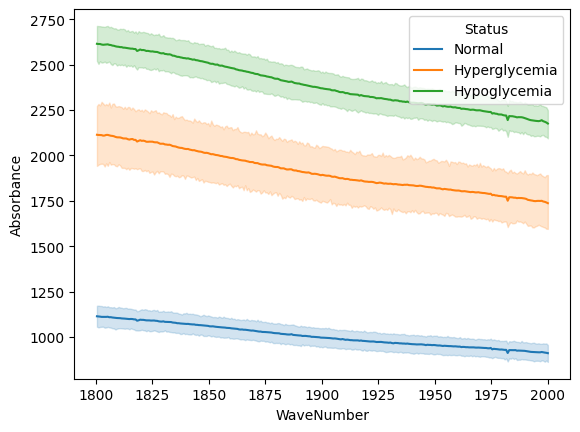

In [28]:
sns.lineplot(data=filtered_df, x='WaveNumber', y='Absorbance', hue='Status')

#### Machine Learning

#### First we will look at the full wavelength.

Create a field for each wavelength.

In [22]:
wavelength_df = filtered_df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
wavelength_df.columns.name = None

Add the statuses back.

In [23]:
statuses = spectra_df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [24]:
wavelength_df.head()

,1800.4556,1801.1389,1801.8223,1802.5057,1803.1891,1803.8724,1804.5558,1805.2391,1805.9226,1806.606,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1180.0099,1222.6375,1217.8395,1224.5698,1216.3939,1214.6156,1191.8302,1203.2986,1210.1285,1209.8872,...,1100.5006,1088.7416,1092.1083,1104.9304,1084.1281,1076.9363,1089.0814,1092.8083,1086.6990,Normal
201210-1-01,1352.1876,1363.1398,1352.8234,1346.5677,1361.6791,1354.6720,1354.0760,1349.3937,1365.1749,1374.0066,...,1246.2748,1270.4456,1272.1703,1271.8768,1270.0718,1283.9667,1286.9803,1276.4037,1268.0922,Normal
201210-1-02,1968.5786,1936.1206,1980.8735,1972.1938,1980.7009,1975.8700,1965.2471,1998.7609,1978.6345,1962.3007,...,2028.6669,2046.8510,2094.8308,2067.8396,2043.0687,2063.5925,2086.6956,2064.7766,2064.2126,Normal
201210-1-03,1968.1050,1957.5809,1996.9305,2006.4016,1999.9272,2023.1279,2020.5510,1982.3582,1991.9509,2020.1472,...,1682.3824,1694.8450,1710.2760,1714.6768,1746.4635,1705.4204,1703.1569,1705.2943,1687.0480,Normal
201210-1-04,1973.3945,1985.8580,1976.0103,1967.1552,1963.7074,1966.4155,1955.4309,1980.7052,1952.1260,1966.8904,...,1725.4711,1722.2786,1757.0481,1745.6029,1728.0017,1750.2548,1747.0122,1756.1727,1747.9722,Normal


##### 1. Training a Random Forest and Extra Trees Classifer on the whole spectrum.

In [25]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [26]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [27]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status'], axis=1)
y = wavelength_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.5560 +/- 0.0223
ExtraTreesClassifier Cross-Validation Accuracy: 0.5632 +/- 0.0195
